In [1]:

# data manipulation
from g2p_client import G2PDatabase
import pandas as pd

# plotting
from IPython.display import set_matplotlib_formats
from __future__ import division
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#  The resulting plots will then also be stored in the notebook document, with big fonts
%matplotlib inline
sns.set(font_scale=2)

# our ES instance
INDEX = 'associations'
HOST = 'elastic'
DATABASE = G2PDatabase(HOST, INDEX)


In [2]:
# get a dataframe with features, environment, features and evidence
# By default this excludes trials and limited to evidence with fully normalized features, environment and phenotype
# ( for the details, pass verbose flag to print query)
associations_df = DATABASE.associations_dataframe(verbose=True)

{
  "query": {
    "query_string": {
      "query": "-source:*trials +features.start:* +association.phenotype.type:* +association.environmentalContexts.id:* "
    }
  },
  "_source": {
    "includes": [
      "source",
      "association.evidence_label",
      "genes",
      "association.phenotype.type.id",
      "association.phenotype.type.term",
      "association.environmentalContexts.id",
      "association.environmentalContexts.term",
      "association.evidence.info.publications",
      "features"
    ]
  }
}
{
  "feature_centric": 17429,
  "evidence_centric": 17429,
  "original": 9056,
  "environment_centric": 17320
}


In [3]:
# as we can see its panda friendly
print associations_df.shape
associations_df.head(4)

(17429, 21)


,environmentalContext.id,environmentalContext.term,evidence.id,evidence_label,feature.alt,feature.biomarker_type,feature.chromosome,feature.description,feature.end,feature.entrez_id,...,feature.genomic_hgvs,feature.name,feature.ref,feature.referenceName,feature.start,gene_list,phenotype.id,phenotype.term,publication_count,source
0,compound:CID10184653,AFATINIB,0WE9MmABo7W0JU3G18ke,D,AA,snp,12,NaN,25398282.0,NaN,...,NC_000012.11:g.25398281_25398282delinsAA,KRAS G13F,CC,GRCh37,25398281,KRAS,DOID:3910,lung adenocarcinoma,2,molecularmatch
1,CHEMBL1201577,CETUXIMAB,0WE9MmABo7W0JU3G18ke,D,AA,snp,12,NaN,25398282.0,NaN,...,NC_000012.11:g.25398281_25398282delinsAA,KRAS G13F,CC,GRCh37,25398281,KRAS,DOID:3910,lung adenocarcinoma,2,molecularmatch
2,CHEMBL1201577,CETUXIMAB,y2E-MmABo7W0JU3GE9GI,C,G,snp,12,NaN,25398284.0,3845.0,...,NC_000012.11:g.25398284C>G,G12A,C,GRCh37,25398284,KRAS,DOID:9256,colorectal cancer,1,civic
3,CHEMBL1201577,CETUXIMAB,y2E-MmABo7W0JU3GE9GI,C,G,snp,12,NaN,25398284.0,3845.0,...,NC_000012.11:g.25398284C>G,G12A,C,GRCh37,25398284,KRAS,DOID:9256,colorectal cancer,1,civic


## Compare denormalized counts vs unique evidence items
* this is a denormalized data frame
* when creating pivot tables, be aware of raw counts vs unique values (use unique values)

In [4]:
counts = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['evidence.id'],
               aggfunc='count',
               fill_value=0,
               margins = True)
uniques = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['evidence.id'],
               aggfunc=lambda _id: len(_id.unique()),
               fill_value=0,
               margins = True)
pd.concat([counts, uniques], axis=1, join_axes=[counts.index])

evidence.id  evidence.id
source         evidence_label                          
cgi            A                       224          212
               B                        13            8
               C                       202          153
               D                       195          159
civic          A                        28           10
               B                       491          222
               C                      1053          512
               D                      1285          570
jax            A                       146           71
               B                       184           81
               C                      1977          863
               D                      8457         3564
molecularmatch A                      1264          700
               B                       167           84
               C                       252          134
               D                      1168          711
oncokb         A                       124           26
               B                        38           13
               C                        53           23
               D                       108           49
All                                  17429         8165

In [5]:
counts = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['feature.genomic_hgvs'],
               aggfunc='count',
               fill_value=0,
               margins = True)
uniques = pd.pivot_table(associations_df, 
               index=['source', 'evidence_label'], 
               values=['feature.genomic_hgvs'],
               aggfunc=lambda _id: len(_id.unique()),
               fill_value=0,
               margins = True)
pd.concat([counts, uniques], axis=1, join_axes=[counts.index])

feature.genomic_hgvs  feature.genomic_hgvs
source         evidence_label                                            
cgi            A                                224                   120
               B                                 13                     4
               C                                202                   111
               D                                195                   114
civic          A                                 28                     5
               B                                491                    67
               C                               1053                   141
               D                               1285                   180
jax            A                                146                    25
               B                                184                    21
               C                               1977                   181
               D                               8457                   418
molecularmatch A                               1264                   293
               B                                167                    69
               C                                252                    91
               D                               1168                   286
oncokb         A                                124                    22
               B                                 38                     7
               C                                 53                    21
               D                                108                    34
All                                           17429                  1211

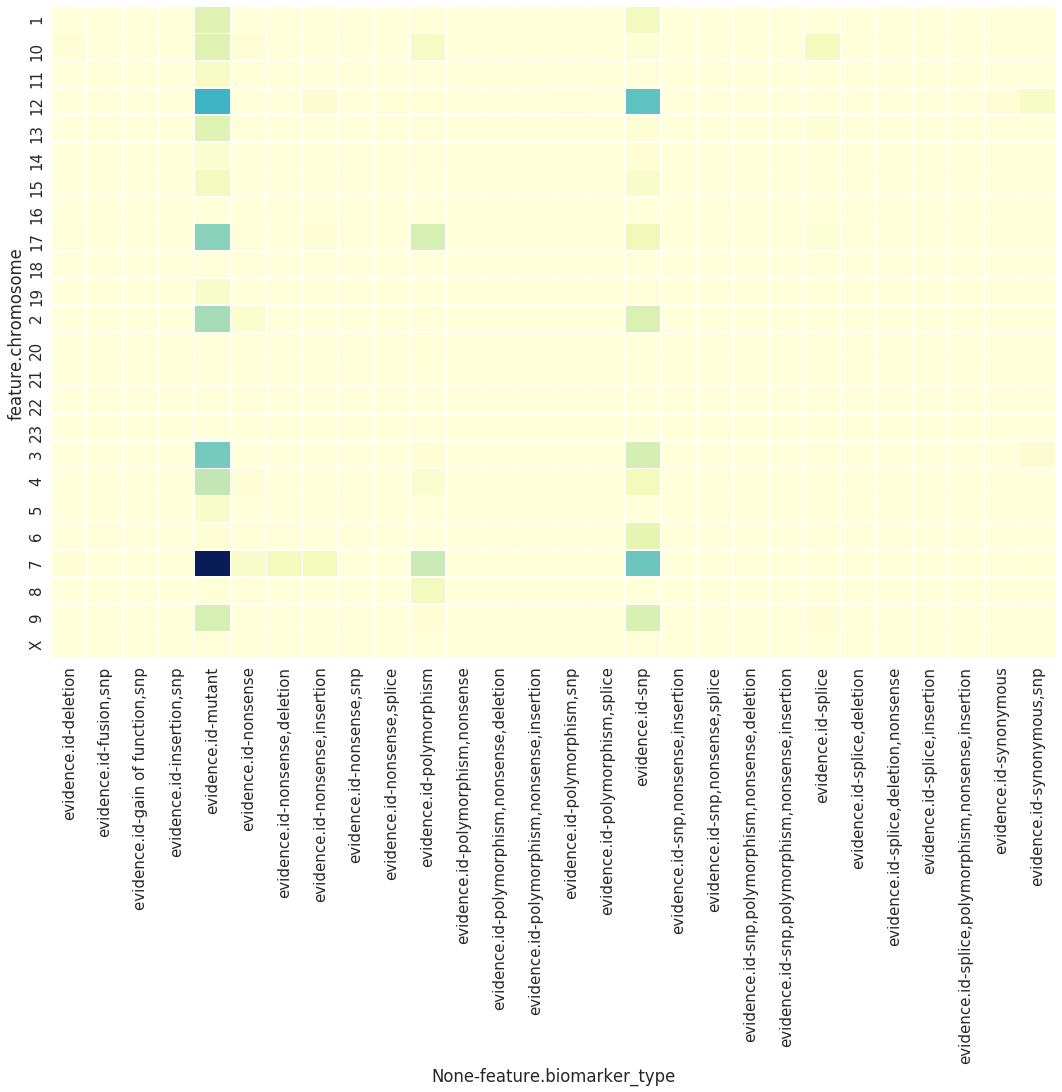

In [6]:
# create a pivot table to sum publication count 
table = pd.pivot_table(associations_df, 
                       index=['feature.chromosome'],
                       columns=['feature.biomarker_type'], 
                       values=['evidence.id'],
                       aggfunc=lambda _id: len(_id.unique()),                       
                       fill_value=0)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set(font_scale=1.5)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(table, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu") 



## G2P Top twenty phenotypes by source

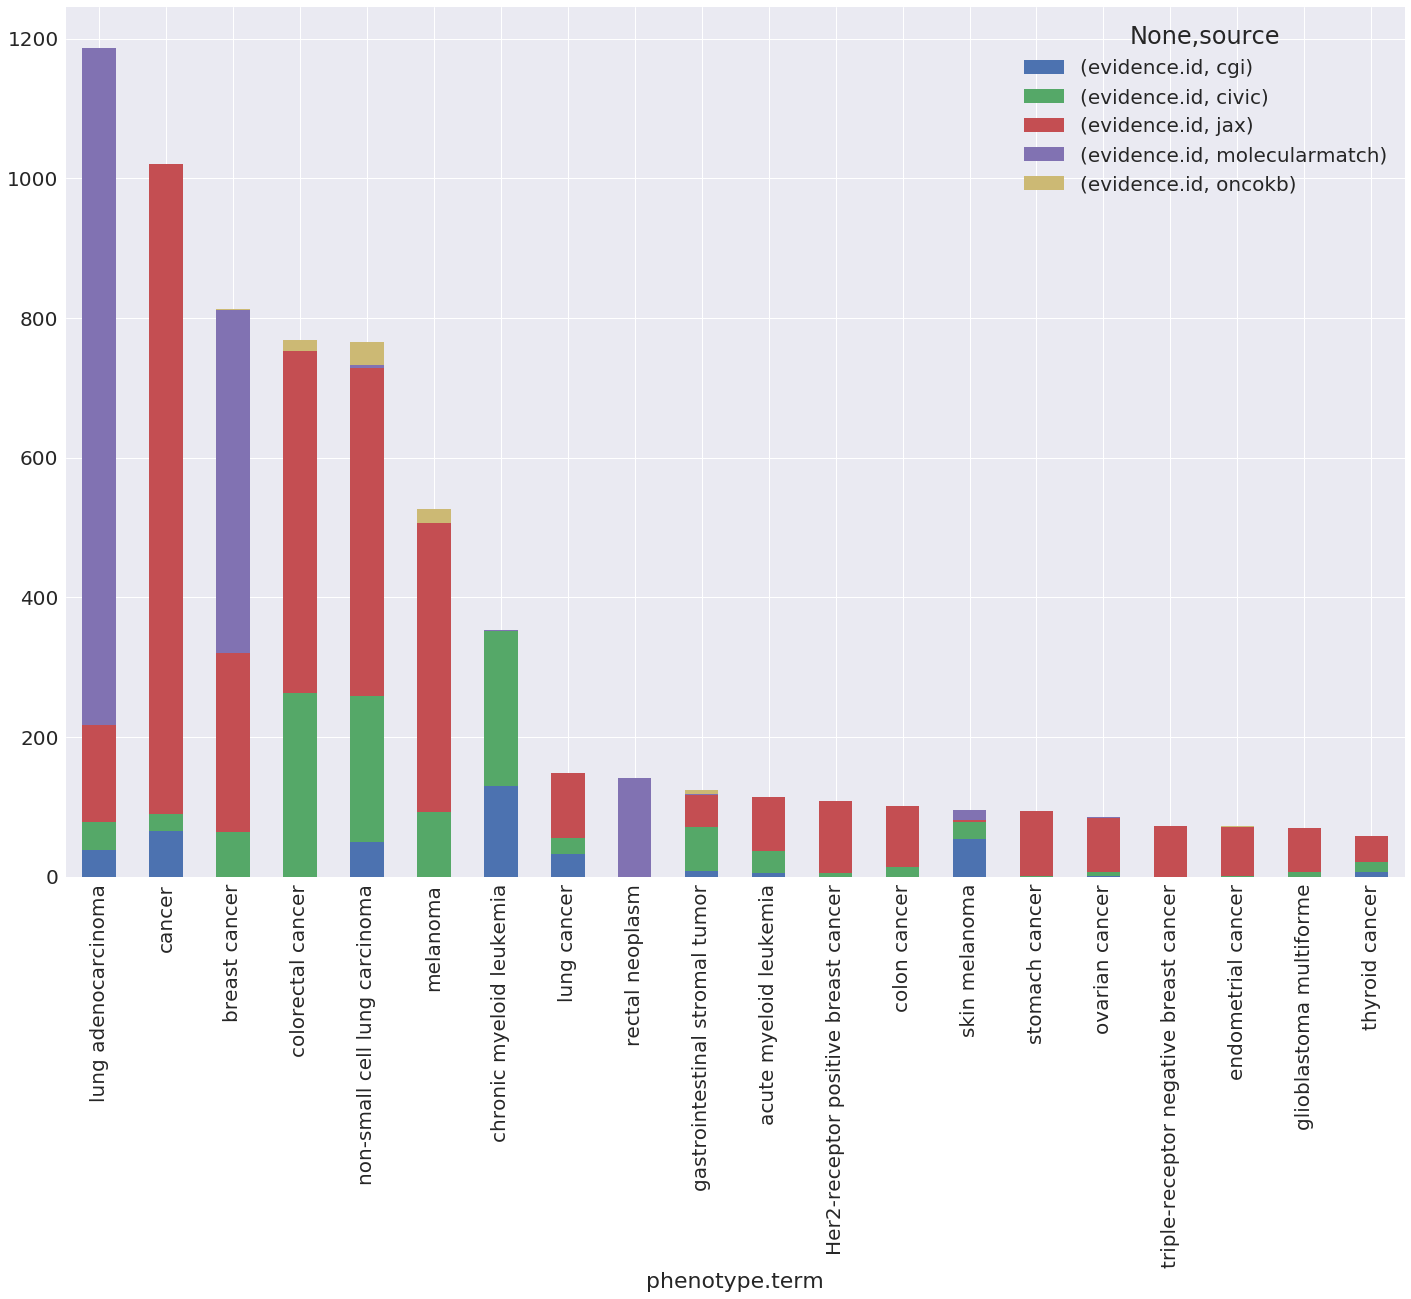

In [7]:
sns.set(font_scale=2)

table = pd.pivot_table(associations_df,
                       index=["phenotype.term","source"],
                       values=['evidence.id'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)

cmp = plt.cm.get_cmap('jet')
s_sort = table.groupby(level=[0]).sum().sort_values(by=['evidence.id'],ascending=False)
table = table.reindex(index=s_sort.index, level=0).unstack(fill_value=0)


table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16))


## G2P Top twenty phenotypes by evidence level

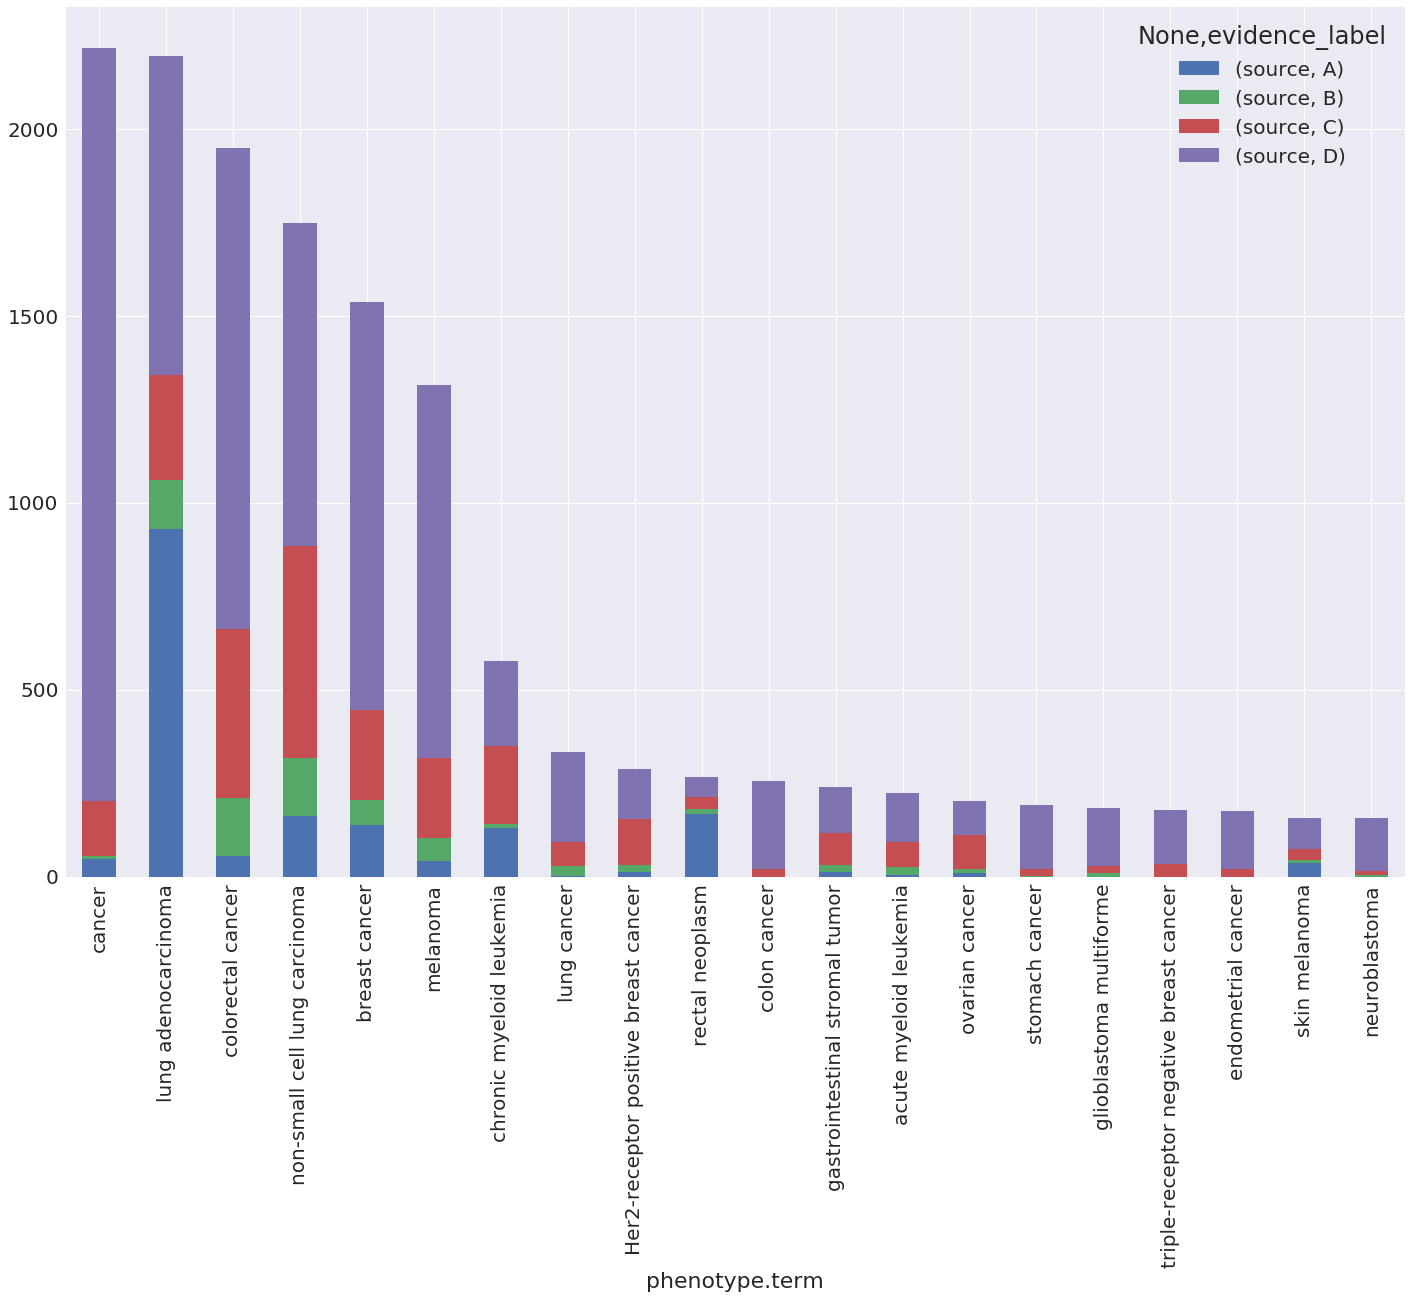

In [8]:
sns.set(font_scale=2)

table = pd.pivot_table(associations_df,
                       index=["phenotype.term","evidence_label"],
                       values=['source'],
                       aggfunc='count')
cmp = plt.cm.get_cmap('jet')
s_sort = table.groupby(level=[0]).sum().sort_values(by=['source'],ascending=False)
table = table.reindex(index=s_sort.index, level=0).unstack(fill_value=0)


table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16))


# G2P Phenotype / Chromosome distribution
* map g2p phenotype to chromosome

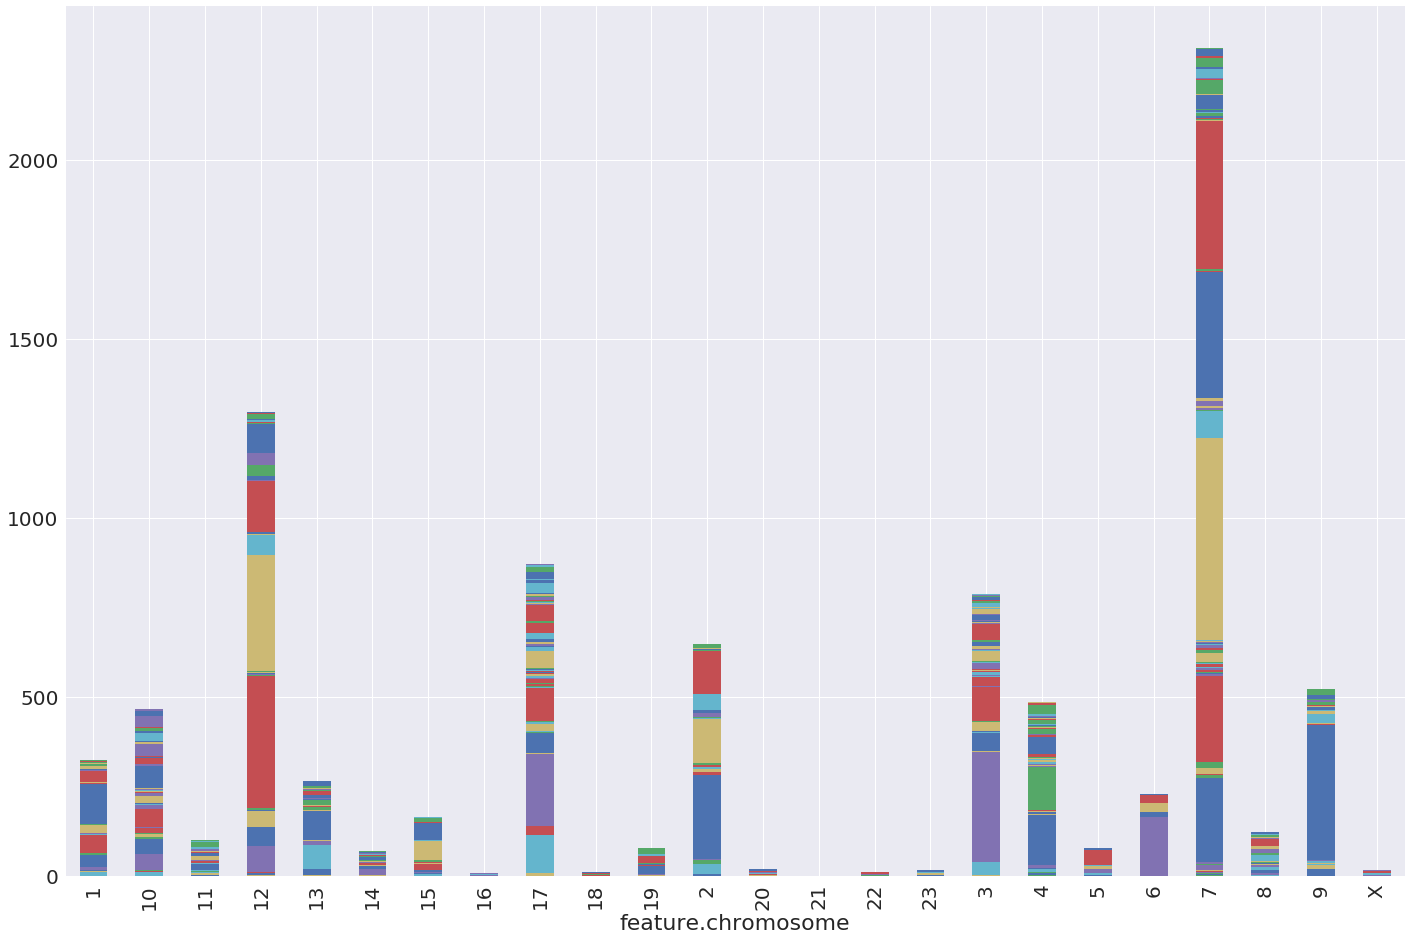

In [9]:
# create a pivot table to sum evidence count by phenotype and chromosome
table = pd.pivot_table(associations_df, 
                       index=['feature.chromosome'],
                       columns=['phenotype.term'], 
                       values=['evidence.id'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)


table.plot(kind='bar',  stacked=True,  figsize=(24, 16), legend=None )


## Load GENIE database
```
NOTE: move to g2p_database.py
```

In [10]:
# Load GENIE variants.
GENIE_VARIANTS = '/util/data_mutations_extended_1.0.1.txt'
GENIE_CLINICAL = '/util/data_clinical_1.0.1.txt'
genie_associations_df =  DATABASE.genie_associations(associations_df, GENIE_VARIANTS, GENIE_CLINICAL)



/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (17,18,23,24,25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# GENIE Tumor Samples / Phenotype / Chromosome distribution
* map genie Tumor_Sample_Barcode to chromosome

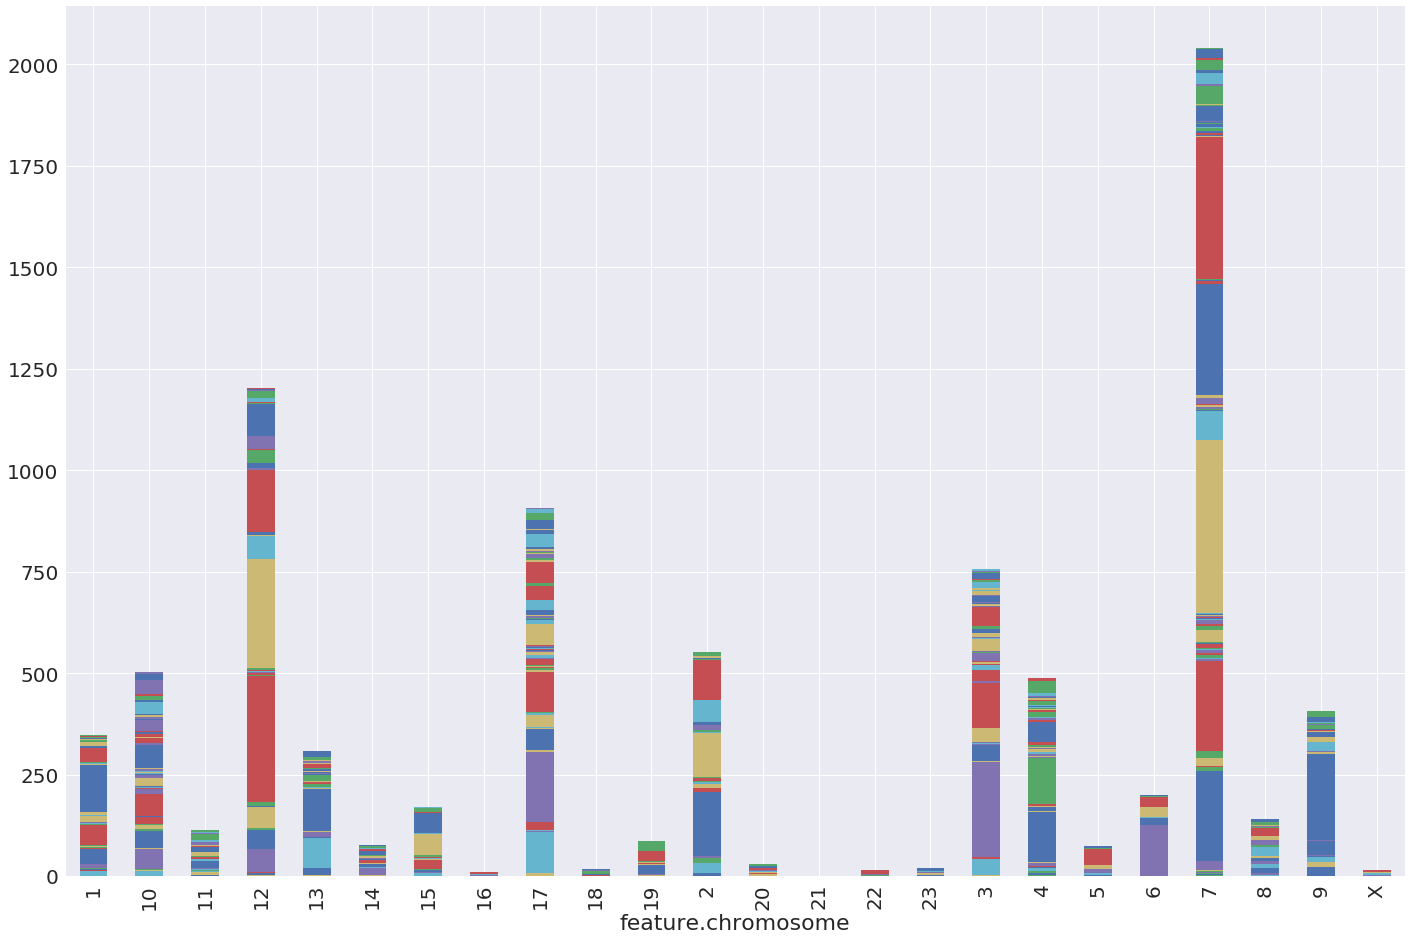

In [14]:
# create a pivot table to sum barcode count by phenotype and chromosome
table = pd.pivot_table(genie_associations_df, 
                       index=['feature.chromosome'],
                       columns=['phenotype.term'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)

table.plot(kind='bar',  stacked=True,  figsize=(24, 16), legend=None )


## GENIE Tumor Samples / Evidence Label / Chromosome distribution
* map genie Tumor_Sample_Barcode to chromosome

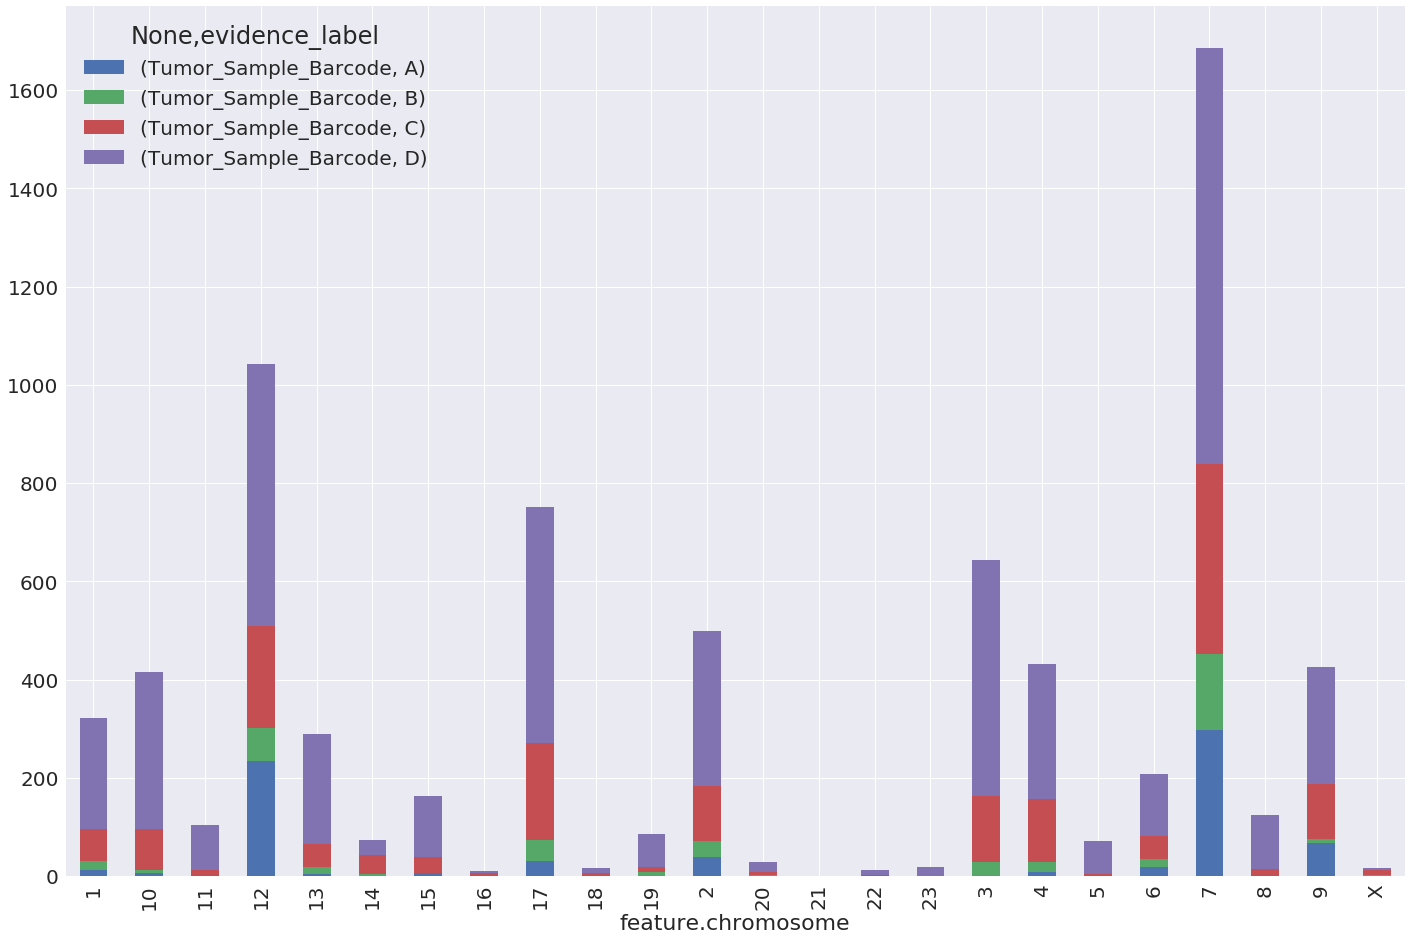

In [15]:

# create a pivot table to sum barcode count by phenotype and chromosome
table = pd.pivot_table(genie_associations_df, 
                       index=['feature.chromosome'],
                       columns=['evidence_label'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0)

table.plot(kind='bar',  stacked=True,  figsize=(24, 16) )


## Top twenty GENIE Tumor Samples / Evidence Label / ONCOTREE  distribution


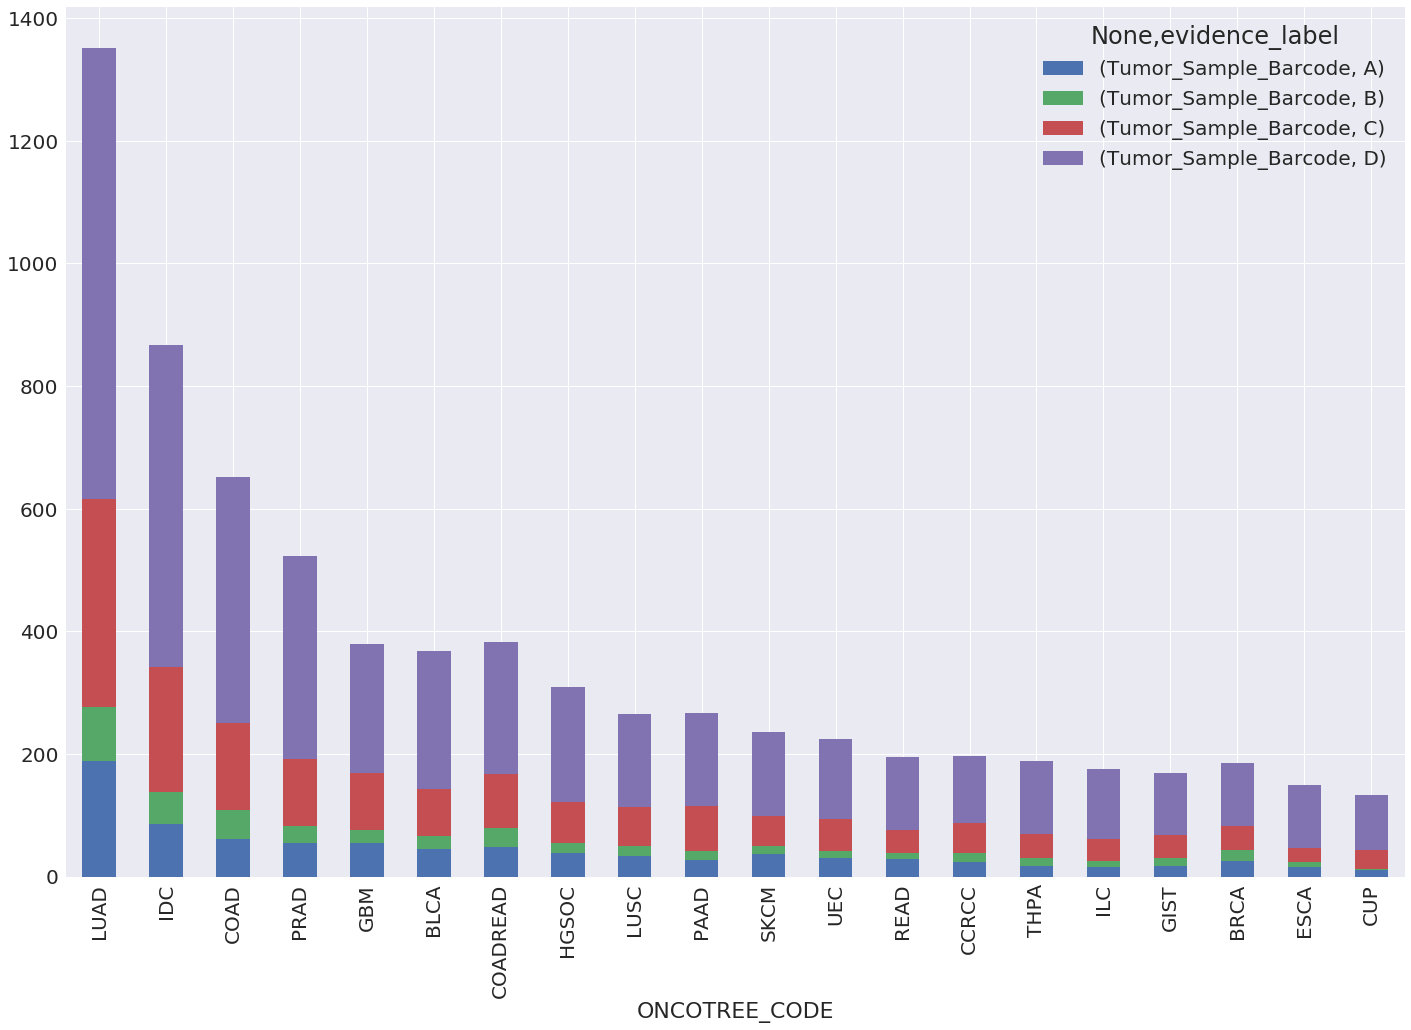

In [16]:

# create a pivot table to sum barcode count by evidence_label and ONCOTREE_CODE
table = pd.pivot_table(genie_associations_df, 
                       index=['ONCOTREE_CODE'],
                       columns=['evidence_label'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0,
                       margins=True
                      )

# sort by the All column total
table.sort_values(by=('Tumor_Sample_Barcode', 'All'), ascending=False,inplace=True)
# now that we are sorted drop the All row and column
table.drop('All',inplace=True)
table.drop('All', axis=1, level=1,inplace=True)
# plot the top 20
table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16) )


## Top twenty GENIE Tumor Samples / source / ONCOTREE  distribution


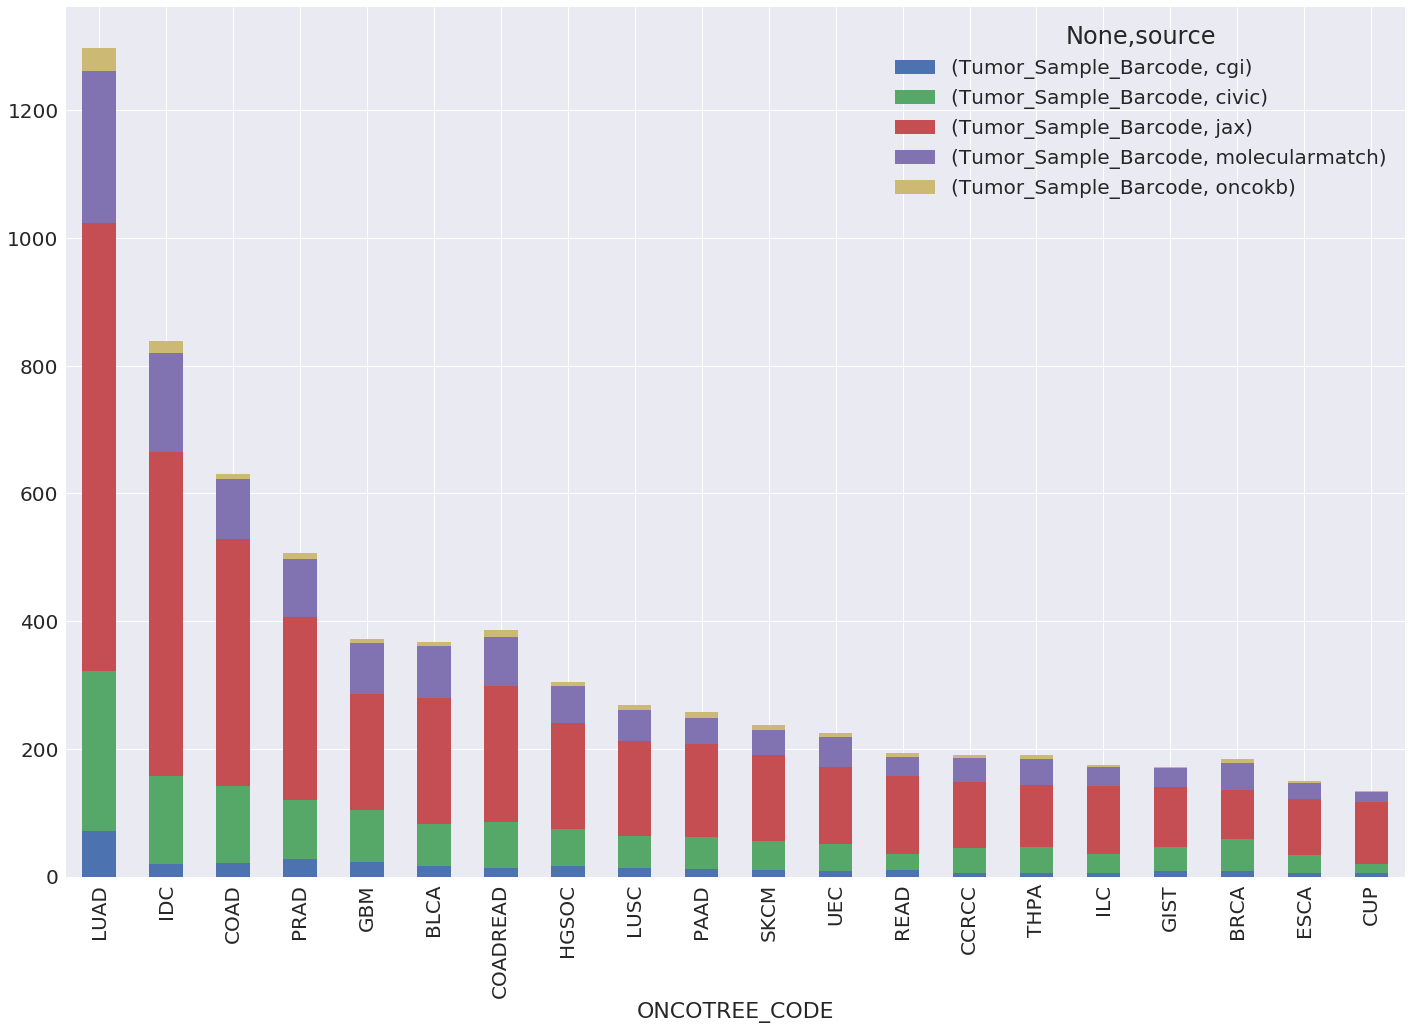

In [17]:

# create a pivot table to sum barcode count by source and ONCOTREE_CODE
table = pd.pivot_table(genie_associations_df, 
                       index=['ONCOTREE_CODE'],
                       columns=['source'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0,
                       margins=True
                      )

# sort by the All column total
table.sort_values(by=('Tumor_Sample_Barcode', 'All'), ascending=False,inplace=True)
# now that we are sorted drop the All row and column
table.drop('All',inplace=True)
table.drop('All', axis=1, level=1,inplace=True)
# plot the top 20
table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16) )


##  Age at sequencing / source / sample  distribution

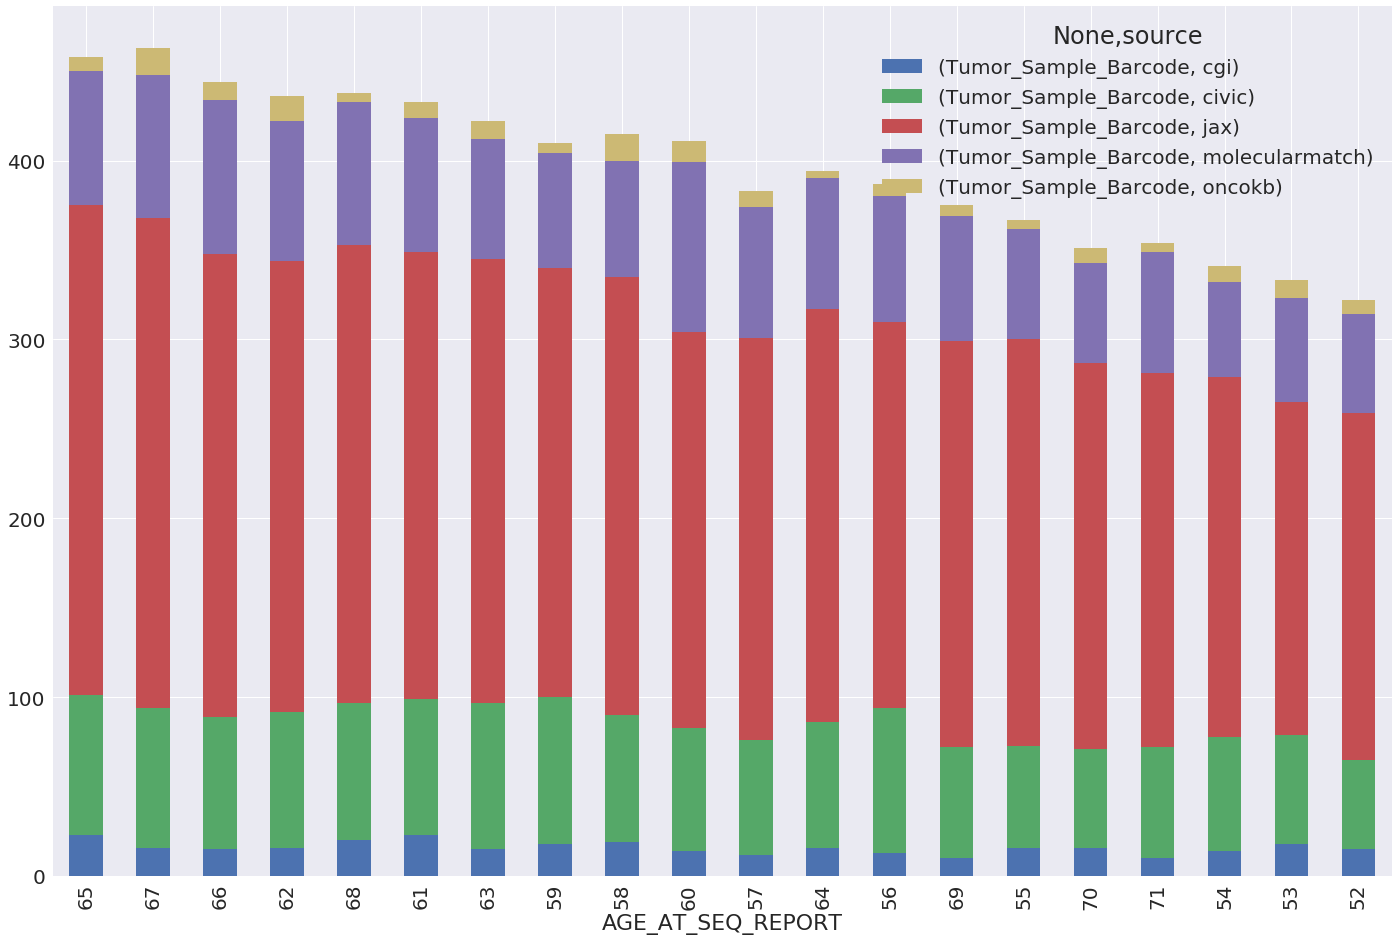

In [18]:

# create a pivot table to sum barcode count by source and AGE_AT_SEQ_REPORT
table = pd.pivot_table(genie_associations_df, 
                       index=['AGE_AT_SEQ_REPORT'],
                       columns=['source'], 
                       values=['Tumor_Sample_Barcode'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0,
                       margins=True
                      )

# sort by the All column total
table.sort_values(by=('Tumor_Sample_Barcode', 'All'), ascending=False,inplace=True)
# now that we are sorted drop the All row and column
table.drop('All',inplace=True)
table.drop('All', axis=1, level=1,inplace=True)
# plot the top 20
table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16) )


 ## Top twenty GENIE Drug / source / ONCOTREE  distribution

Text(0,0.5,u'number of drugs')

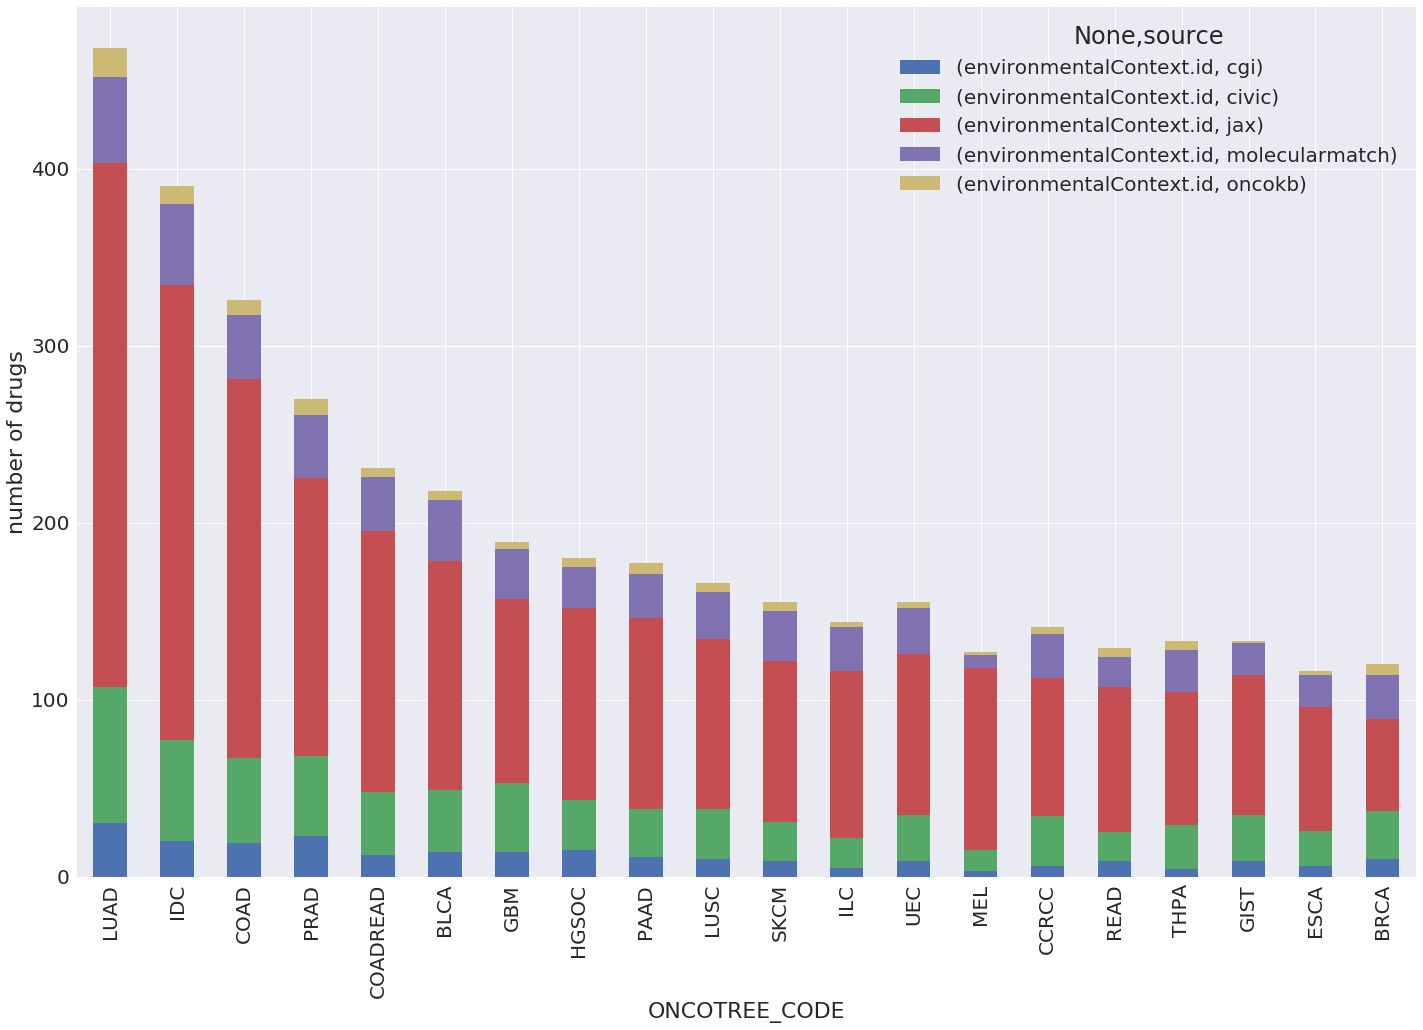

In [19]:

# create a pivot table to sum environmentalContext count by source and ONCOTREE_CODE
table = pd.pivot_table(genie_associations_df, 
                       index=['ONCOTREE_CODE'],
                       columns=['source'], 
                       values=['environmentalContext.id'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0,
                       margins=True
                      )

# sort by the All column total
table.sort_values(by=('environmentalContext.id', 'All'), ascending=False,inplace=True)
# now that we are sorted drop the All row and column
table.drop('All',inplace=True)
table.drop('All', axis=1, level=1,inplace=True)
# plot the top 20
ax = table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16) )
ax.set_ylabel("number of drugs")



Text(0,0.5,u'number of drugs')

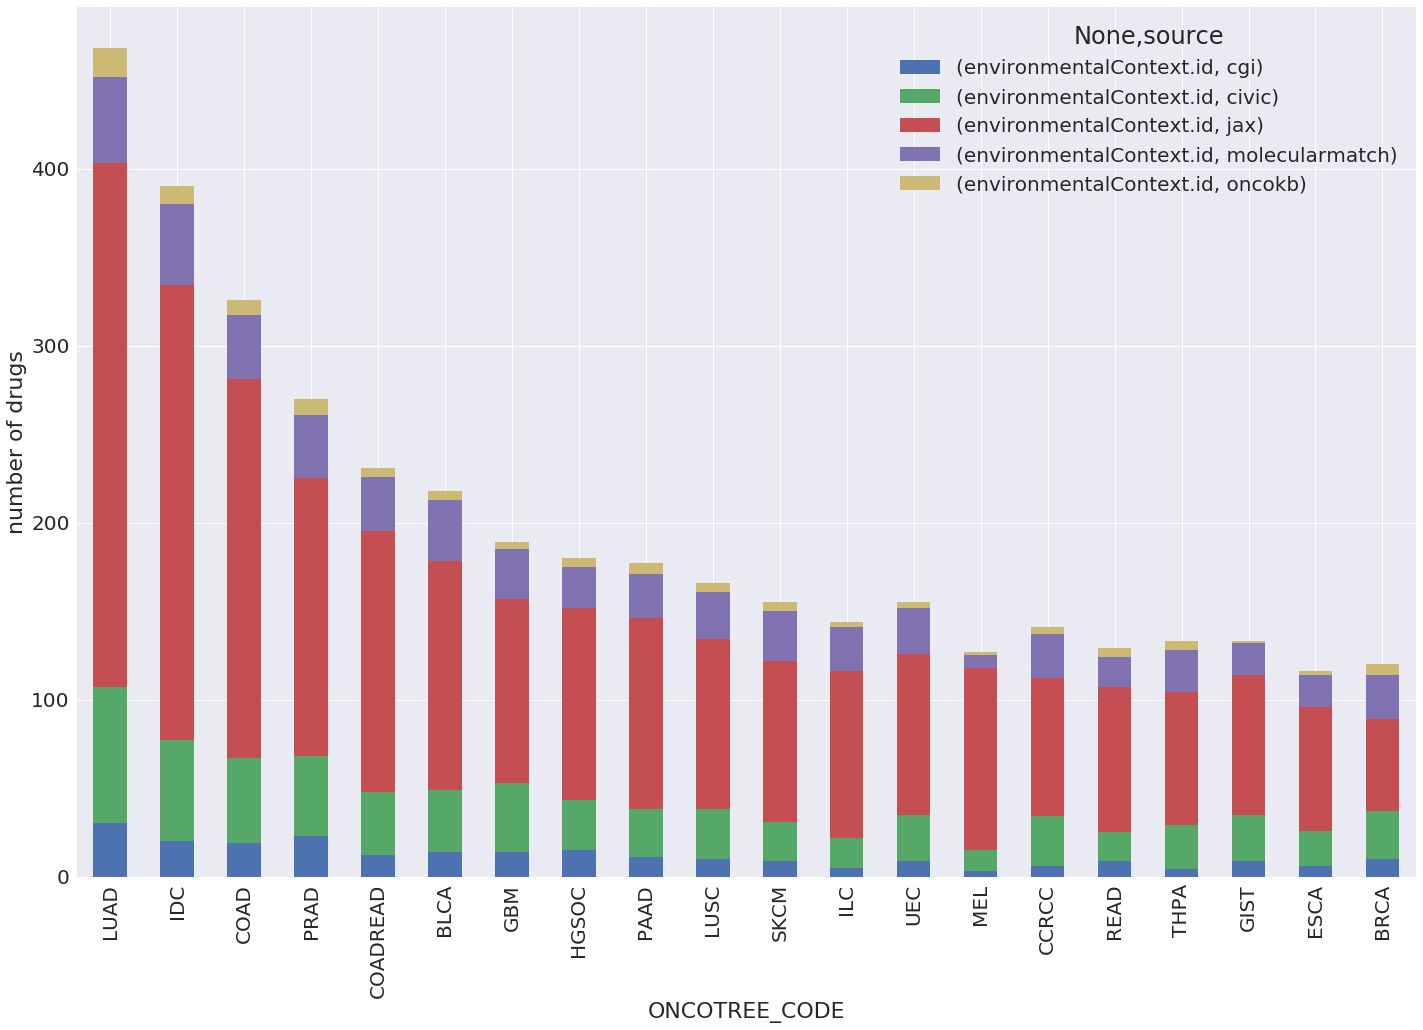

In [20]:

# create a pivot table to sum environmentalContext count by source and ONCOTREE_CODE
table = pd.pivot_table(genie_associations_df, 
                       index=['ONCOTREE_CODE'],
                       columns=['source'], 
                       values=['environmentalContext.id'],
                       aggfunc=lambda _id: len(_id.unique()),                                              
                       fill_value=0,
                       margins=True
                      )

# sort by the All column total
table.sort_values(by=('environmentalContext.id', 'All'), ascending=False,inplace=True)
# now that we are sorted drop the All row and column
table.drop('All',inplace=True)
table.drop('All', axis=1, level=1,inplace=True)
# plot the top 20
ax = table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16) )
ax.set_ylabel("number of drugs")



Text(0,0.5,u'number of samples')

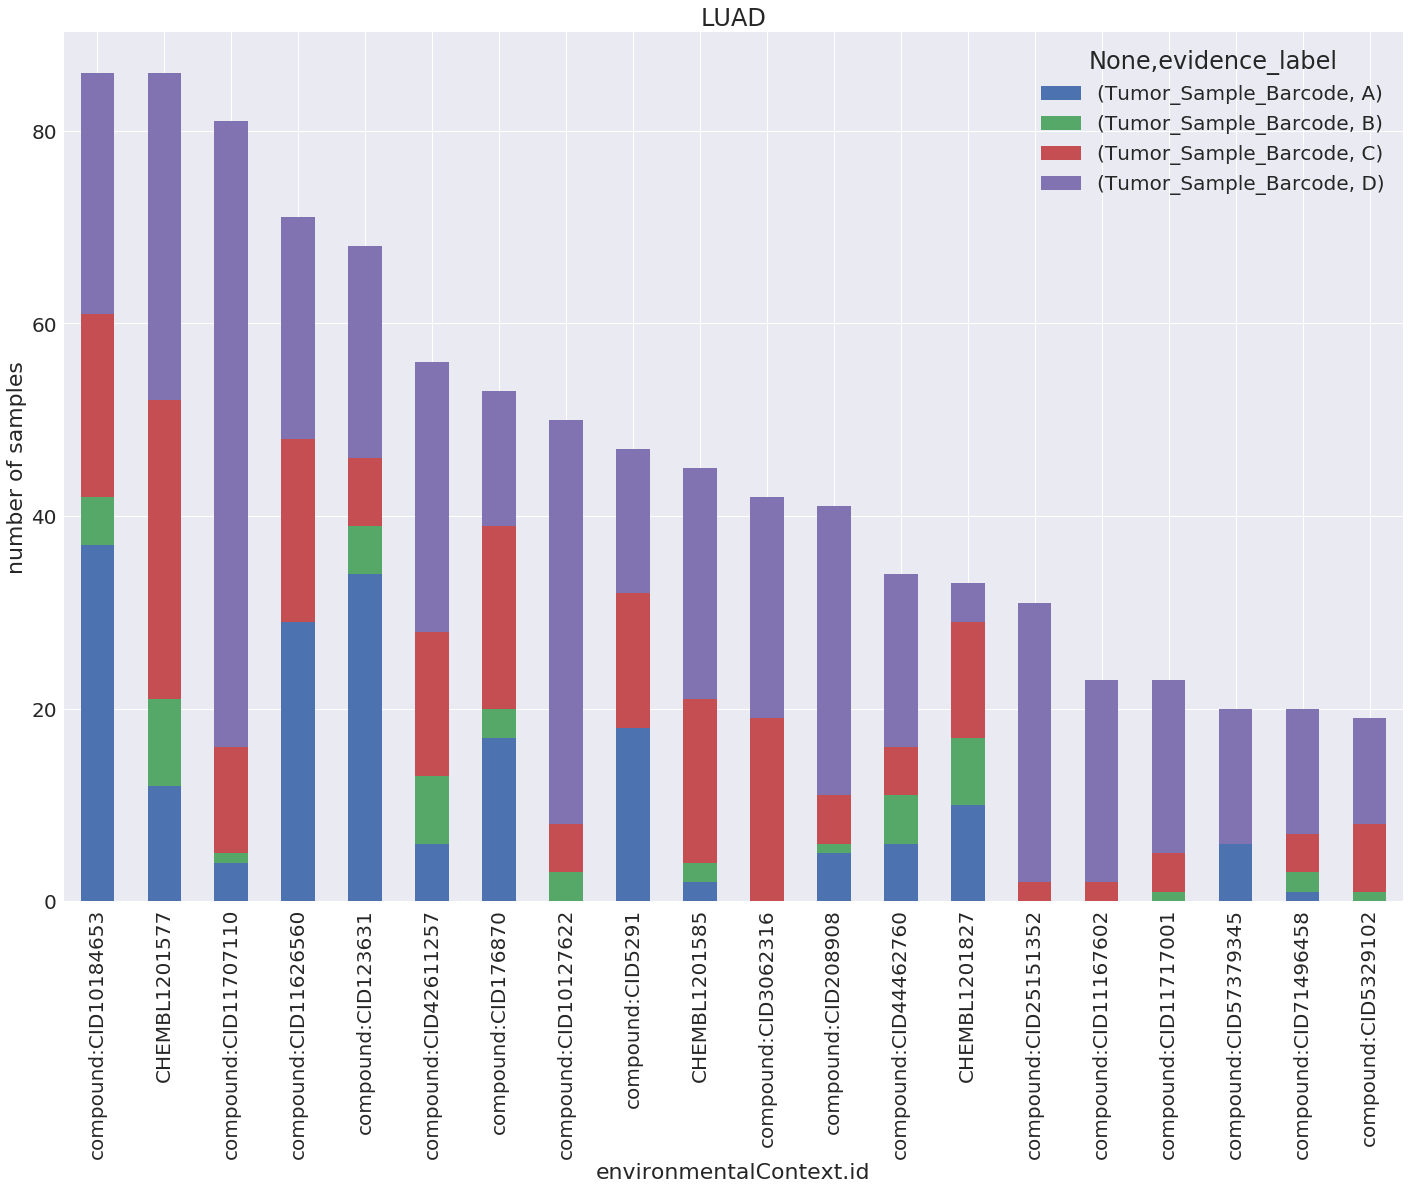

In [21]:
# create a pivot table to sum barcode count by environmentalContext and ONCOTREE_CODE

table =  pd.pivot_table(genie_associations_df.query('ONCOTREE_CODE=="LUAD"'), 
    index=['environmentalContext.id'], 
    columns=[ 'evidence_label'],           
    values=['Tumor_Sample_Barcode'],
    aggfunc=lambda _id: len(_id.unique()),
    fill_value=0,
    margins = True)


# # # sort by the All column total
table.sort_values(by=('Tumor_Sample_Barcode', 'All'), ascending=False, inplace=True)
# # # # now that we are sorted drop the All row and column
table.drop('All',inplace=True)
table.drop('All', axis=1, level=1,inplace=True)

# plot the top 20
ax = table.head(20).plot(kind='bar',  stacked=True,  figsize=(24, 16) , title='LUAD' )
ax.set_ylabel("number of samples")
